In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os

import numpy as np
import tensorflow as tf
import deepchem as dc

from deepchem.utils.save import load_from_disk
from deepchem.feat.graph_features import ConvMolFeaturizer, WeaveFeaturizer

input_data='./ChEMBL/hDAT_pIC50.csv'

tasks = ['affinity','standard_value']
#featurizer=WeaveFeaturizer()
featurizer=ConvMolFeaturizer()


loader = dc.data.CSVLoader(tasks=tasks, smiles_field="canonical_smiles",featurizer=featurizer)
dataset=loader.featurize(input_data)


Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./ChEMBL/hDAT_pIC50.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 2.804 s
TIMING: dataset construction took 3.200 s
Loading dataset from disk.


In [2]:
import deepchem as dc
import tempfile, shutil
from deepchem.splits.splitters import RandomSplitter

splitter=RandomSplitter()
train_data,valid_data,test_data=splitter.train_valid_test_split(dataset)



TIMING: dataset construction took 0.515 s
Loading dataset from disk.
TIMING: dataset construction took 0.235 s
Loading dataset from disk.
TIMING: dataset construction took 0.229 s
Loading dataset from disk.


In [3]:
from deepchem.models.tensorgraph.tensor_graph import TensorGraph

tg = TensorGraph(use_queue=False)




In [4]:
from deepchem.models.tensorgraph.layers import Feature

atom_features = Feature(shape=(None, 75))
degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
membership = Feature(shape=(None,), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
    deg_adjs.append(deg_adj)


In [5]:
from deepchem.models.tensorgraph.layers import Dense, GraphConv, BatchNorm
from deepchem.models.tensorgraph.layers import GraphPool, GraphGather

batch_size = 50

gc1 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[atom_features, degree_slice, membership] + deg_adjs)
batch_norm1 = BatchNorm(in_layers=[gc1])
gp1 = GraphPool(in_layers=[batch_norm1, degree_slice, membership] + deg_adjs)
gc2 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm2 = BatchNorm(in_layers=[gc2])
gp2 = GraphPool(in_layers=[batch_norm2, degree_slice, membership] + deg_adjs)
dense = Dense(out_channels=128, activation_fn=tf.nn.relu, in_layers=[gp2])
batch_norm3 = BatchNorm(in_layers=[dense])
readout = GraphGather(
    batch_size=batch_size,
    activation_fn=tf.nn.tanh,
    in_layers=[batch_norm3, degree_slice, membership] + deg_adjs)

In [9]:
from deepchem.models.tensorgraph.layers import Dense, ReduceSquareDifference, WeightedError, Stack
from deepchem.models.tensorgraph.layers import Label, Weights

costs = []
labels = []
for task in range(len(tasks)):
    #classification = Dense(out_channels=2, activation_fn=None, in_layers=[readout])
    regression = Dense(out_channels=1, activation_fn=None, in_layers=[readout])
    tg.add_output(regression)

    label = Label(shape=(None, 1))
    labels.append(label)
    cost = ReduceSquareDifference(in_layers=[label, regression])
    costs.append(cost)
    
    
weights = Weights(shape=(None, len(tasks)))
loss = WeightedError(in_layers=[costs, weights])
tg.set_loss(loss)

AttributeError: 'list' object has no attribute 'name'

In [7]:
from deepchem.metrics import rms_score
from deepchem.feat.mol_graphs import ConvMol

def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
    for epoch in range(epochs):
        if not predict:
            print('Starting epoch %i' % epoch)
        for ind, (X_b, y_b, w_b, ids_b) in enumerate(
            dataset.iterbatches(
                batch_size, pad_batches=pad_batches, deterministic=True)):
            d = {}
            for index, label in enumerate(labels):
                d[label] = y_b[:, index]
            d[weights] = w_b
            multiConvMol = ConvMol.agglomerate_mols(X_b)
            d[atom_features] = multiConvMol.get_atom_features()
            d[degree_slice] = multiConvMol.deg_slice
            d[membership] = multiConvMol.membership
            for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
                d[deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
            yield d

In [8]:
tg.fit_generator(data_generator(train_data, epochs=1))

/home/nagayasu/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Starting epoch 0


ValueError: Cannot feed value of shape (50,) for Tensor 'Label_31/Placeholder:0', which has shape '(?, 2)'

In [48]:


from sklearn.metrics import mean_absolute_error
from deepchem.metrics import rms_score
import deepchem.hyper.grid_search

metric = dc.metrics.Metric(
    mean_absolute_error, task_averager=np.mean, mode="regression")

train_score_list = []
valid_score_list = []

model.fit(train_data, nb_epoch=500)

#or i in range(0,100):
#   model.fit(train_data, nb_epoch=10*i)

#   train_scores = model.evaluate(train_data, [metric])

#   valid_scores = model.evaluate(valid_data, [metric])
    
#   train_score_list.append(train_scores)
#   valid_score_list.append(valid_scores)
    

(177, 1)
(177, 1)
(177, 1)


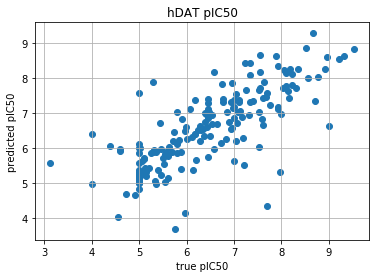

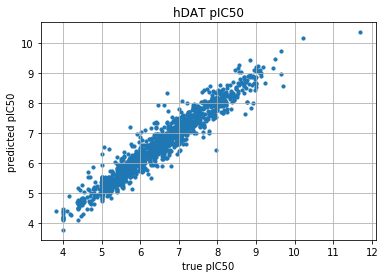

In [50]:
import matplotlib.pyplot as plt


a1 = np.reshape(valid_data.ids, (-1,1))
a2 = np.reshape(model.predict_proba(valid_data), (-1,1))
a3 = valid_data.y

print(np.shape(a1))
print(np.shape(a2))
print(np.shape(a3))


a4 = np.concatenate((a1,a2,a3), axis=1)
#print(np.shape(a4))
#print(a4)

a11 = np.reshape(train_data.ids, (-1,1))
a21 = np.reshape(model.predict_proba(train_data), (-1,1))
a31 = train_data.y

a41 = np.concatenate((a11,a21,a31), axis=1)
#print(np.shape(a41))
#print(a41)

plt.scatter(a4[:,2], a4[:,1])
plt.title("hDAT pIC50")
plt.xlabel("true pIC50")
plt.ylabel("predicted pIC50")
plt.grid(True)
plt.show()

plt.scatter(a41[:,2], a41[:,1],s=10)
plt.title("hDAT pIC50")
plt.xlabel("true pIC50")
plt.ylabel("predicted pIC50")
plt.grid(True)
plt.show()

In [32]:
import scipy as sp
from scipy.stats import pearsonr, spearmanr

x = a41[:,1].astype(np.float32)
y = a41[:,2].astype(np.float32)

print(pearsonr(x,y))
print(spearmanr(x,y))

x = a4[:,1].astype(np.float32)
y = a4[:,2].astype(np.float32)

print(pearsonr(x,y))
print(spearmanr(x,y))

(0.9021668, 0.0)
SpearmanrResult(correlation=0.9045004227712112, pvalue=0.0)
(0.47491464, 2.411845083411097e-11)
SpearmanrResult(correlation=0.4234650287547709, pvalue=4.2902636530277395e-09)
